<a href="https://colab.research.google.com/github/ninopira/generate_bz_lyric_2021/blob/main/train_scrach_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pprint

import pandas as pd
import torch
from torch import nn
import tqdm
import numpy as np
from matplotlib import pyplot as plt

mecabのinstall  
verを落とさないといけないらしい。https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer

In [2]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl lib

In [3]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :   

In [4]:
import MeCab
import subprocess

cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
m = MeCab.Tagger(path)
print(m.parse("彼女はペンパイナッポーアッポーペンと恋ダンスを踊った。"))

彼女	名詞,代名詞,一般,*,*,*,彼女,カノジョ,カノジョ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
ペンパイナッポーアッポーペン	名詞,一般,*,*,*,*,*
と	助詞,並立助詞,*,*,*,*,と,ト,ト
恋	名詞,一般,*,*,*,*,恋,コイ,コイ
ダンス	名詞,サ変接続,*,*,*,*,ダンス,ダンス,ダンス
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
踊っ	動詞,自立,*,*,五段・ラ行,連用タ接続,踊る,オドッ,オドッ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
。	記号,句点,*,*,*,*,。,。,。
EOS



# データ準備

In [5]:
df = pd.read_csv('/content/drive/MyDrive/other/generate_bz_lyrics/df_all.csv')
print(df.shape)
df.head()

(347, 6)


,URL,SongName,Artist,Lyricist,Composer,lyrics
0,https://www.uta-net.com/song/54892/,I WANNA DANCE Wicked Beat Style,B'z,Kohshi Inaba,Takahiro Matsumoto,Crush! Crush! Taxi on a busy neon streetGive m...
1,https://www.uta-net.com/song/7938/,あいかわらずなボクら,B'z,稲葉浩志,松本孝弘,今まで好きなこともしたし たまに我慢もしてきた「あいつはダメだ」 なんてキミ勝手に決めないで...
2,https://www.uta-net.com/song/17979/,愛と憎しみのハジマリ,B'z,KOSHI INABA,TAK MATSUMOTO,誰もが愛する者 守ろうとしてる頃 憎しみがスキをうかがう大破綻の雰囲気が世界中を取り巻いて朝...
3,https://www.uta-net.com/song/25415/,愛のバクダン,B'z,稲葉浩志,松本孝弘,今日も一日 不完全な世界きみが泣かなくても 誰か泣く人がこしらえた 悲しみのからくりなんとか...
4,https://www.uta-net.com/song/26049/,愛のprisoner,B'z,KOSHI INABA,TAK MATSUMOTO,"I hate you, hate you こらえきれずに夜の闇に吠える 涙流さないあなたのど..."


## 日本語的な前処理

In [7]:
lyrics = df['lyrics']

In [8]:
def remove_full_width_and_wow(text):
    removed = text.replace('\u3000', '')
    removed = removed.replace('\n', '')
    removed = removed.replace('wow', '')
    removed = removed.replace('NA', '')
    return removed

lyrics = [remove_full_width_and_wow(lyric) for lyric in lyrics]

In [9]:
tagger = MeCab.Tagger(path)
def wakatigaki(text):
    word_list = []
    for word_id, elm in enumerate(tagger.parse(text).split('\n')):
        if elm and elm != 'EOS':
            elm = elm.split('\t')
            info = elm[1].split(',')
            word_list.append(elm[0])
    return word_list
lyrics = [wakatigaki(lyric) for lyric in lyrics]

In [10]:
lyrics[200][:20]

['かわいい',
 '寝息',
 'たて',
 'て',
 'ねむる',
 '愛しい',
 '子',
 'なごり',
 '惜しげ',
 'に',
 'ゆっくり',
 '明かり',
 '消す',
 'よ',
 '明日',
 'も',
 '一緒',
 'に',
 '笑い',
 'あえ']

# 単語を数字に変換

初めて辞書を作成する場合

In [11]:
words = []
for lyric in lyrics:
    for word in lyric:
        if word not in words:
            words.append(word)
word = sorted(set(words))
word2num = dict((c, i) for i, c in enumerate(words))
num2word = dict((i, c) for i, c in enumerate(words))

print(len(words))

8910


In [ ]:
df_word_num = pd.DataFrame(word2num, index=['i', ]).T
df_word_num = df_word_num.reset_index()
df_word_num.columns = ['word', 'num']
df_word_num = df_word_num.to_csv('/content/drive/MyDrive/other/generate_bz_lyrics/df_word_num.csv', index=False)
df_word_num

辞書を作成済みの場合

In [12]:
df_word_num = pd.read_csv('/content/drive/MyDrive/other/generate_bz_lyrics/df_word_num.csv')
word2num = df_word_num.set_index('word')['num'].to_dict()
num2word = df_word_num.set_index('num')['word'].to_dict()
num2word[20]

'kill'

# Model

In [14]:
class RNNModule(nn.Module):
  def __init__(self, n_vocab, embedding_size, hidden_size):
    super(RNNModule, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(n_vocab, embedding_size)
    self.lstm = nn.LSTM(embedding_size,
                        self.hidden_size,
                        bidirectional=False,
                        batch_first=True)
    self.dense = nn.Linear(self.hidden_size, 2000)
    self.final = nn.Linear(2000, n_vocab)
  def forward(self, x, prev_state):
    embed = self.embedding(x)
    output, state = self.lstm(embed, prev_state)
    x = self.dense(output)
    logits = self.final(x)
    return logits, state
  def zero_state(self, batch_size):
    return (torch.zeros(1, batch_size, self.hidden_size),  torch.zeros(1, batch_size, self.hidden_size))

# 学習

In [15]:
def generate(model, prime_str=['夏', 'の'], predict_len=100, temperature=0.8, device='cuda'):
    model.eval()
    model.to(device)
    state_forward_h, state_forward_c = model.zero_state(batch_size=1)
    for p in range(predict_len):
        prime_input = torch.tensor([word2num[w] for w in prime_str]).to(device)
        prime_input = prime_input.unsqueeze(0)  # add batch_size=1

        state_forward_h = state_forward_h.to(device)
        state_forward_c = state_forward_c.to(device)
        logits, (state_forward_h, state_forward_c) = model(prime_input, (state_forward_h, state_forward_c))
        logits = logits[:, -1]
        
        output_dist = logits.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0].detach().cpu().numpy())
        predicted_word = num2word[top_i]
        prime_str.append(predicted_word)
    return prime_str

In [17]:
## 前準備
model = RNNModule(n_vocab=len(words), embedding_size=500, hidden_size=1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print('before_train')
generate_sentence = generate(model, prime_str=['夏', 'の'], predict_len=100, temperature=0.8, device='cpu')
pprint.pprint(' '.join(generate_sentence), width=70)

# maxlen単語から次の1単語を予測するタスク
# x: maxlen単語, y: 1単語
# (maxlen単語、1単語) -> step単語スキップ -> (maxlen単語、1単語)を繰り返し
num_epochs = 30
maxlen = 10
step = 3
batch_size = 50
model_weight_dir = '/content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/'
os.makedirs(model_weight_dir, exist_ok=True)

loss = 0
train_losses_epochs = []
for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    model = model.to(device)
    batch_x = []
    batch_y = []
    train_losses_batch = []
    model.train()
    for lyric in tqdm.notebook.tqdm(lyrics):
        state_forward_h, state_forward_c = model.zero_state(batch_size)
        state_forward_h = state_forward_h.to(device)
        state_forward_c = state_forward_c.to(device)
        
        for i in range(0, len(lyric) - maxlen, step):
            # データの準備. batch_size1で学習
            sentences = lyric[i: i + maxlen]
            sentences = [word2num[w] for w in sentences]
            batch_x.append(sentences)
            next_words = [lyric[i + maxlen]]
            next_words = [word2num[w] for w in next_words]
            batch_y.append(next_words)

            if len(batch_x) == batch_size:
                batch_x = [torch.tensor(sentences).unsqueeze(0) for sentences in batch_x]
                batch_x = torch.stack(batch_x,dim=0).reshape(batch_size, maxlen)
                batch_x = batch_x.to(device)

                batch_y = [torch.tensor(next_words) for next_words in batch_y]
                batch_y = torch.tensor(batch_y).to(device)

                # 重みの更新
                optimizer.zero_grad()
                logits, _ = model(batch_x,  (state_forward_h, state_forward_c))
                logits = logits[:, -1]  # (batch, seq_len, , num_words) -> (batch, num_words)
                loss = criterion(logits, batch_y)
                loss.backward(retain_graph=True)
                optimizer.step()
                train_losses_batch.append(loss.item())
                batch_x = []
                batch_y = []

    # 1曲終わり、最後に余ったbatchがあれば学習
    if len(batch_x) != 0:
        tmp_batch_size = len(batch_x)
        state_forward_h, state_forward_c = model.zero_state(tmp_batch_size)
        state_forward_h = state_forward_h.to(device)
        state_forward_c = state_forward_c.to(device)

        batch_x = [torch.tensor(sentences).unsqueeze(0) for sentences in batch_x]
        batch_x = torch.stack(batch_x, dim=0).reshape(tmp_batch_size, maxlen)
        batch_x = batch_x.to(device)

        batch_y = [torch.tensor(next_words) for next_words in batch_y]
        batch_y = torch.tensor(batch_y).to(device)

        # 重みの更新
        optimizer.zero_grad()
        logits, _ = model(batch_x,  (state_forward_h, state_forward_c))
        logits = logits[:, -1]  # (batch, seq_len, , num_words) -> (batch, num_words)
        loss = criterion(logits, batch_y)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses_batch.append(loss.item())
        batch_x = []
        batch_y = []

    train_losses_epoch  = np.mean(train_losses_batch)
    print('epoch:', epoch + 1, 'loss', train_losses_epoch)
    train_losses_epochs.append(train_losses_epoch)
    generate_sentence = generate(model, prime_str=['夏', 'の'], predict_len=100, temperature=0.8, device='cpu')
    pprint.pprint(' '.join(generate_sentence), width=70)

    if (epoch+1) % 5 == 0:
        model_path = os.path.join(model_weight_dir, f'ep_{epoch+1}.pth')
        print('save_model;', model_path)
        torch.save(model, model_path)

cuda
before_train
('夏 の 溶ける さま なく なれ カッ 悪気 路地 芽ぶく changingI キ テール かわり 町 本当は 当然 魅惑 自ら '
 '叫べる フイ 箱 作 満たさ おしまい DEVILTOKYO 就職 いかさま フムキ やがて AGAIN 半分 Affair '
 'raindrops 忘れよ RUN バリバリ Like 時計 捨て身 涙 恋愛 ゴージャス pay まくる ませ じじ 決まっ '
 'fireStickin もて 飛び散る 羽ばたく ゆけれ SOUL 見違える 一夜漬け 昨今 削っ 落ち着け many みるみる '
 'じゃう 狂う 差す ぐしょぐしょ Action ものすごい どり 舐める ALL 忍び寄る 品定め 動揺 stepsBut 一夜漬け '
 '分から みずみずしい 本気 出会う 待た satisfactionFake 嘲笑 まっしぐら 変わる 精いっぱい あく ドレス '
 'ふりむい がたい 切る truthIt 味わい深く たげ のに つべこべ ぼう 信号 ビョーキ S Wash 晴れ渡る 結ば')



epoch: 1 loss 7.208832651190071
('夏 の いい加減 させ か でも で 花びら よ くし ここ に this あなた の 吹きとばさ を fearYou て い ない '
 'の よう に パッ 捨て ない で か 今 でも … … に 愛しい て ゆく は 脆い て ゆく た でも も ない か の 中 '
 'そして よ もの 君 の 悪 を 楽しく て くれ そして そう どんな 瞳 の 愛 can に よ そば て もう 今 の よう '
 'に of 心 た まま は ホント う 微熱 を 見 て も イタイケ 草原 に ない で しか で 僕 を sideNothing '
 'て い て いく の もと')



epoch: 2 loss 5.8572168469677885
('夏 の 中 を のばし て いっ う ぎりぬけがけもう って に ある の は 自身 を 答え た こと は 今 を 見せよ の は '
 'けど 自分 を 飛ばし 何 も ない よ 命 ずっと で 欲しい ない 僕 は すごし 何もかも ない よ シャツ に まみれ た '
 'かなえ れ ない よ よ ドライバー ない よ 届い こと は 僕 を 変え て しまう た … 時間 ぬ 楽園 を にぎっ た の '
 'こと は はなやい ない よ 焦燥 なにもかも is こと かけがえ の ない もの は 叫ぼ ない こと は 仕方 う いつ わけ '
 'の 心 を 作っ て も 恋')



epoch: 3 loss 5.13119946441969
('夏 の ベジタブル を あげよ よう に 吸い込ま た & シャワー 萎ま に 柔かい ない で も ない から やっぱり 今 の '
 'なら まだ ない よ ONE で ストロー て ひたすら 正気 痛み 星 何 も 見つから ない 自分 に 愛せ は ない スマイル '
 'ない 今 を ずっと 見 た の 痛み 人 は もう おもう じゃ ない と 目 は 同じ でき ない で も 記憶 ない で から '
 'はじめりゃ て い ない よ イカ まで 激しい を つけ て 恥 の は まだ 人 に も ない これ 欲しい の ない … の '
 '背中 を 駆け に なっ て 道')



epoch: 4 loss 4.390881091667366
('夏 の 色 を さがし に ALONE ない 僕 を さがし ほど て ゆく の よ つなぎとめ ない つながら 欲しい 時 の '
 'ない から 素晴らしい の よう に Rosy も 誰か を っと の 中 で そば に ひとつ の よう に 会う れ ない よ '
 'THE たきゃ それ だけ は 今 すぐ LIFE 1 なく て よ る なきゃ あなた に 見え ない 誰 か なんか て しまう '
 'から なん ながら なんか A は まだ 何 でも 命 なく なる の そんな 誰 の か 僕 も 見 そう た とか じゃ ない '
 'と ずっと は ない よ この わざわざ に')



epoch: 5 loss 3.569762125642414
('夏 の 中目 を N laugh の ない で だ 涙 の だろ う N の & に 待っ れ 毎日 だけ は 誰 の 背中 に '
 'ある だろ う ? れ た 僕 は 君 の こと を 見 た 罪 の は いつも に ねえ ない 逃がし は いっしょ に も あり '
 "に い たい 捨て 君 は 僕 だけ を 見せよ う N かな I ' m a my way ... … Are The like "
 'like of in - go aroundLike the the of in the riverWash wing you , '
 'my right to the of the nowKoishikarubeki in of')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_5.pth



epoch: 6 loss 2.7145731136171705
('夏 の 真ん中 も しぼん の は 壊れ の 声 は そこ の よう に どんな の は 誰 か 無理矢理 の ？ 腕 それ が '
 'こぼれる おまえ の は いっそ A だろ う N ちょっと の ない 僕 は 何 ひとつ 憎しみ に 言葉 は られ ない の さ '
 "ばっか let ' s dancelove the ? mindLove てりゃ the love of the man of of "
 "the reason sky go baby , just for ' s all her wanna make me we can "
 'in the come WILD our 問いかけ nowKoishikarubeki - the the night and '
 "sky the one and I ' re")



epoch: 7 loss 1.9433663560851382
('夏 の Komachi も ある の 欲し は 今日 の 自分 を 連れ込む てる から い ない で 人生 は 特別 の My '
 "ところ 側 の 僕 は 僕 の 最高 だ すぐ 雲 は い 雨 ど だって ' s wing make it , round of "
 "We roundBut the love it , right now I don ' ll turn have Are her "
 "enough roundBut do ' s baby , baby baby ' Hey , do ' s roundBut … "
 "Hey Hey It 立て , say - we Kimi our , Hey ' s roundBut still the "
 "love you our 燃える '")



epoch: 8 loss 1.3067688405638198
('夏 の () を い た の は い なく いつか それ は まだ なっ た って すべて が 見え すぎ の ？ それ は いら '
 'もの どんな か ？ 理由 は holeinmyheart onDon の 公約 も Oh で ふくらん turn it all '
 "何故 モンダイナイ know I ' love youC with do ' me your tonight 離し 苦く - 覚ます "
 "to another do to like so many to empty to the enough love ' s "
 "enough ' s wing do it ' s so time to get glow do it on my さらけだせ ' "
 "s enough ナイ with do we ' IN")



epoch: 9 loss 0.8336454096691593
('夏 の 持ち を もっと どこ か 教え で 新しい 新しい の が 見せる 綺麗 の 中 教え の 中 たち は いら だ よ 波 '
 "側 baby , hey を 楽 ' IN ROCK do な do - our し てる の 教え man ) 素晴らしい 娘 "
 "溶かし の 針 永遠 , 永遠 ほんの her do - it 作 laging 楽 ' IN IN THE ) THE do 妙 "
 'the to , to ときどき man do - do and man to the candle days night long '
 'in enough we need naked need to be 後生大事 , round , say it love')



epoch: 10 loss 0.4922502667396203
('夏 の 理由 を もっと すり減らす Way なら ない 永遠 の 電話 を 噛ん 我が身 終わら DEAD の 匂い どんなに '
 'MAILRosy 卒業 動かさ 離さ 瞳 時 妙 に もう Under の 教え ( My Oh yes One やん らん 歩い '
 '永遠 また 強い め へ の 気持ち 掴ん の ONE 破り の 匂い 恋しく で 生命 の boy せつない は もう 貴女 '
 'Rosy Rosy … 胸 の 家 恨みつらみ を 橋 ケリ 見せよ まっか ああ まっか Loving と 待っ yan 感じ '
 '人生 Loving の 終わら を 変え の は とびのっ も 記憶 変 の ある だろ 電話 は My man か 勘違い')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_10.pth



epoch: 11 loss 0.2688237910930822
('夏 の 日 を 叫ん で 卒業 で 無邪気 れる と 入れ 毎日 余裕 も それ が さだめ だ どう と 感じ 笑い ON '
 'どんなに My 離さ 時 の 中 が 涙 の 中 で 眠っ てる の 卒業 教え を Oh ところ は 何処 でしょ に の 闇 の '
 '中 で 電話 を 遠き 歌お どこ か でも 新しい 新しい 新しい ゆっくり の 朝 ONE の 上 に たち の 中 で やら '
 '( Are 愛 !) ) 情熱 の 未来 は もう 終わら ない 昨日 を どんなに One を 忘れ ちゃ さ は 大地 だ から '
 '涙 どう 出 、')



epoch: 12 loss 0.1455456300644449
('夏 の 顔 を もっと life 生まれ た 夢 の 勝手 で ソフトクリーム たら 声 それ が よみがえる の ど ど 終わら '
 "笑っ がる で BABY ( 熱い 側 でも 側 It 明るい 電話 ' s time do day モンダイナイ ナイ ナイ "
 'じっと 永遠 ああ だけ が 永遠 また BABY ズバッ の 中 も 教え で も 黙っ また ソフトクリーム 僕ら は もう '
 '終わら わかる 愛 にゃ ど また 側 It It 期待 ゆっくり ああ = ( 熱い !) の よう よう に 波 を せつない '
 'まま で ゆく ああ まっすぐ まっすぐ 胸 の 波 歌お かい na に 電話 は 汗')



epoch: 13 loss 0.09536848299881921
('夏 の 力 を 噛ん て 踊る てる はず の 毎日 など ない わかる どんなに ほんの ため の 色 黒い よく がる で 太陽 '
 'は 忘れ 終わり それ は 生き て また また ずっと 忘れ て き た の 教え It っ で It にゃ また 燃える へ と '
 'き て しまう と き ながら 歩い 手 を つない で 何 ひとつ ゃらちゃらしてろよ の スペシャル の 卒業 青春 頬 の '
 'よう に まっすぐ よう に はじけ 風 と わずか で くれ 闇 の スピード に Rosy 君 を 晴れ れ なく は 悪い で '
 'どんなに 熱い 愛 の 海 の よう に')



epoch: 14 loss 0.07465528848625735
('夏 の 海 を 開け で 鳴らし た 時 に ひとつ 勇気 の よう に すべて 腕 愛する の It ばかり う の 砂 の 中 '
 '響い 腕 ラスベガス It 恋 は 触れる の 海 は 無く の 遠き 側 愛 を また let あげる 二 切り で 大地 her '
 'ステキ days let take her WAN her her 儚い 永遠 her your 値札 効果 たま たま we '
 "have roundBut now ON , do ME ME it ' s nothing time to change 二 ( "
 "Oh Yeah 熱い , I ' ll keep on her her your her your Devil ' come on")



epoch: 15 loss 0.061691021295905986
('夏 の 海 を 自由 で 歩く おまえ に 小さな ( そういう やつ を her 捨て と 値札 どんなに Girl 手 未来 '
 'やめ を Jive そして 痛み の 心 の 悲しみ さよなら 見せる どんなに 切れ IN に ずっと の 海 を きらめく かい '
 '歩い で たやすく It ま よう な の 気持ち 今 の 暮らし は ブルー ブルー 愛 の ある に ブルー は もう 心 が '
 '浮かぶ コーヒー さ れ た よう よう に 消え られ ない くやし を 守っ ず て 言っ て みせ て は やさし だ よ '
 'SUPER が なん だ と 思わ と 雲 れ てる それ')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_15.pth



epoch: 16 loss 0.05288969215865019
('夏 の 針 で 夢 の 中 で 同じ 時間 わかり 距離 心 の 流れ 見せる で let me like , Hey la It '
 'Hey Give , Hey boy はつ 部屋 で おくれ 人生 ) おしまい 生き て 生きる 毎日 た きみ の 中 で それ '
 '花 それ は 生き ( 忘れ ない 街 よう に 死ん れる It 君 に 入れ て しまう 愛 れ た 後 覚まし cry てる '
 'よう な 未来 だれ 手 卒業 川 で かなえ ( キ・ミ・ この よ さよなら どんなに 強く を つけ よう に 生きる '
 'ゆっくり で ぶつかっ で Dance を 喰い よう に ひたすら')



epoch: 17 loss 0.050448092191610366
('夏 の 炎 に い た よう な 極上 へ この 手 を 包ん で 思わず 我が身 卒業 別れ だって 気 に 強く い する 君 '
 'の 声 が 手 を 見せる もう一度 と ずっと かも かも 悪い に ( ま とき そして 色 にゃ THE 達 言っ 感じ て '
 'あげる もう一度 街 を あやす を 振っ て 痛み と もう一度 ( Hey brother 未来 の 教え を さよなら と '
 '聞い する そんな 勇気 の 姿 を 美貌 たら 買い がる 夢見 せ よ 先 に 正体 見せる まで 行き 値札 を 待つ 電話 '
 'を 踊る の そんな 人 の 卒業 どんなに')



epoch: 18 loss 0.053092018833835
('夏 の 時間 は 早い じゃ ない マイ ライフ こと 好き 遠い マイ 決め どんな のに 怖 家 そして 家 と 見せ ず 我慢 '
 'かも ん 穴 人生 だ 恋 の 休み の 心 を 往く ましょ れ ば It の 髪 Are の 海 卒業 だ とか 離し の 卒業 '
 'だ の 中 を 今 僕 は 僕 は 気圧され ます けど 愛 は 一つ 希望 手 なんて 泥沼 海 を 見せよ 消し たっ な 気 '
 'さ ちょうだい やめ … 今 … … … … … … … … … … … … … … … … … … … …')



epoch: 19 loss 0.055503836683229016
('夏 の Komachi いっそ もっと おっことし で 太陽 ば 僕 を 何一つ で 太陽 が ベソ 型 だ から 明るい の ？ '
 '生身 に は はじけ 過ぎ て も いつしか 君 だけ 胸 に 包ま たく どんなに かけ なる と ALONE れ そんな 気 が '
 '笑い 潮 よ それでも 正体 見せる と に ある 以上 以上 出 て くれ 夜 が 悲しい あっ 時 の ため 抱い 知れ !) '
 'に いれ て くる 光 と 娘 出 歩い て 歩い て くる かも 後ろ を 捨て の ため の 教え に やら れ て おくれ '
 '赤い の 道 を 悲しみ 中 で')



epoch: 20 loss 0.09084721970311628
('夏 の ただ で い た 僕ら の それぞれ の もの の 中 で なんだか 残る だ 想い いっしょ に は はじけ ら も いる '
 'その ひとつ で 大地 に 祈る てる 背中 ばかり 夢見 て こわれ に がっかり 晴れ ない 強い 何もかも に 過ぎ て やり '
 'たい 気づか 別れ 強く 抱きしめ ながら あっ てる 卒業 入れ は どんな 幻 きれ 全て も きっと 一緒 を 隠し 燃え盛る '
 '歩い よく tell me 毎日 など 一 の 中 の 中 で 笑い よがり を 笑えよ この まま まま ない まま どうか '
 'BABY … 見せよ … 夕べ いつ まで 続く まで ゆく 僕 を')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_20.pth



epoch: 21 loss 0.047020062689508056
('夏 の 上 で ダメ ウワベ れ て Fool ず に 振り て 逢い で まみれ まみれ 頬 BABY を 浮かべ よう に 手 '
 'を みせろ と DIVE の よう な 言葉 で 祈り を 喰い て かろうじて 好き な 罪 は その 嵐 で 手 を 振っ 振り '
 'ない で 非常 かけ は 僕 も 期待 も 出 に なれ ん だ と 思う 逢う よう な 予感 どう すれ こと の ？ 深い の '
 '休み は baby どんな コエテユケ ？ 好き もの うち に しっかり 一 枚 自ら ば かかっ me in the go は '
 'is 現代 time 燃える 燃える')



epoch: 22 loss 0.03228672137114536
('夏 の 理由 を にぎる 遠き から ある はず なら 感情 ない で よ ね それでも かい で 感じ 歩い て 歩い たい かも '
 'しれ ない そば に 別れ ば 楽し の よう に 何 ( でも たぶん ) に また 決まり の の 電話 破り gotta 誰か '
 'を 入れ なる の 教え を 喰い し て み から 窓 を 悲しみ ... あなた の ある だろ う 僕 の は 君 だけ の '
 '中 で 君 の こと イミシン 誰 に こと が 静か に ある 裏 ついてる こと きり ない もの かい 持つ た こと すべて '
 'と こと そのまま ましょ')



epoch: 23 loss 0.026830663843059013
('夏 の しっぽ を 通る や 書きとめ ない 我が身 を 追い 振り に 強く ゆっくり Girl て みる を 捨て う と '
 "だって たま 何 も かも 出し ない 泣い で そば に また ひとつ Hey It It あなた ' s 汗 ひと も Fool "
 '愛し また ひとつ の ど さえ 中 の 中 で 同じ 時間 の 中 で 感じ て いる こと 知ら ない もの が すべて を '
 '離し て いる はず の かも 胸 に ばかり し て なんか こぼれる なさい キョロキョロ かも 夢見 せ かも まま しれ '
 'All ( 戦争 海 捨て せ 海 に 後悔 海 せる')



epoch: 24 loss 0.02273380488987491
('夏 の 理由 を 払う てる きっと きっと のに おまえ よく 星 の 星 を 中 で 落ち ない 毎日 一 DIVE の ため '
 'に 心 が LIFE さえ LIFE 愛しい 当然 すべて が すべて が ラララ 中 で また 迷い だけ = 夜 ほう つい て '
 'くる 世界 が すべて 想い と 笑っ に いれ ば 別れ の Life 嘘 の 潜む 時 を 聞か せ て する よう に そんな '
 'れる が 体 さえ だ ラララ とっくに 新しい ややこしい ひとつ の ボク を 聞か 中 で やら どんなに 小さな '
 'じゃんじゃん を 同じ まま 海 の 中 で なんだか 恋 の')



epoch: 25 loss 0.024319699179553202
('夏 の 中 で 綺麗 綺麗 じゃ ない そのまま A 目 が 好き だ もん もう な なら 誰 か が 消え て いる ど まわり '
 '信じる くらい ( no , we ) 空回り れる で ほんの てる の が どっか Love 愛しい また ひとつ の 中 も '
 '感じ ダメ の 娘 の ちゃう とか 許す 笑い み て くる ましょ う 波 の THE 憎み 涙 な 言葉 も 愛しい ない ( '
 'なんて 道 に この 部屋 を 夢見 て しまお う と し て いる なら 誰 に 見 た 髪 を 自由 よう に 海 う '
 'スピード の 波')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_25.pth



epoch: 26 loss 0.031927371419973996
("夏 の ? 卒業 そういう ' re 風 に 燃えつきる 暮らし が つい た まま 街 に 道 の 心 を 橋 小さな 出せ "
 "あなた の 未来 穴 で 卒業 海 を むけ よう に 旅 の 新しい I ' m on my way way そつ ない 君 は "
 'so に 懐かしく ば いい ん だ とか で 歩い て しまう 歩い の せい に 別れ の 中 で 南 同じ の 潜む の 時間 '
 'を 追いかける 小さな で 宇宙 で いる の 教え で ソフトクリーム 誰 の ため の 教え で とっくに 明日 の 影 で '
 '僕ら の 背中 ほうり の')



epoch: 27 loss 0.08856517689240345
('夏 の 海 を 合わせよ た きっと きっと 愛 じゃ ない から もう 遅い じゃ ない 顔 を 見せ られ ない あなた の 見 '
 'た 言葉 を 強く 抱きしめ た たいし 手 忘れ てる やつ 悪い に 炎 の スピード に 生き て 歩い られ ない 君 が '
 'この 部屋 は BABY … 心から ちゃ い ない ？ どんな よう に やり ない よう に ただ 痛み でも この 胸 に '
 '朝日 は いる その 日 に いる の よう に 満たさ よう に 汗 たい ロンリースターズ 暴れ たい All 見つけだし たい '
 'All たい All たい 知ら ない only ます ます か')



epoch: 28 loss 0.04489102493193864
('夏 の 海 を 鳴らし てる オリジナル はず た きっと きっと 好き だ よ ふやけ じゃ ない 手 を とっ ば 春 will '
 'から 大丈夫 さよなら こわれよ の が 光る お 見せる どんなに GO ( 熱い の は ) だ night 因果 はず ん だ '
 'と うなずけ が 聞こえる て お気に入り で おまえ は 愛しい おまえ が そう そのうち たび そう やっ て くれ ねむれ '
 'ない 喜怒哀楽 才能 に 輝く あざやか すぎる 時間 の 疲れ 時間 に いる よう に 満ち に 力 が いる いる 旗 黒い '
 '壁 だ 時 の 流れ を どっぷり よう に 汗 かけ 心 も 怖')



epoch: 29 loss 0.021078851044329664
('夏 の 中 で ボク た 店 を 眺め たどる の 果て ( 暗い ) それ それ それ が いい もん と わから て い た よ '
 'かも 消え て いけ ない 夢 を 見 られ て なさい そしたら の 前 を また 救わ ばかり で どんなに と 心配 の こと '
 '想う AND 心から など 旅 で つけ を つけ て くれ へ と さ で Just 人 で よ 言い訳 と 強く あっ て くれ '
 'ねむれ の 髪 を はじめる せ ず に 朝日 を 入れ て さ れる で 風 に 乱さ 暮らし れ ない よう に スピード お '
 'ロンリースターズ')



epoch: 30 loss 0.023197506114282493
('夏 の よう に はじけ 聞こえ た 涙 の まま に は 何 も ない 確か の 波 は いら なんだか ぬくもり & だけ だ '
 'から now 寄せ て 僕ら の こと は 今 力 を 浮かべ 落ち 人生 歩い ばかり の もの が ひとり で 僕ら は 道 中 '
 'で も 同じ 時間 は 今 中 微笑む の 中 で 君 の 日々 で 胸 が 過ごし て いる なら GO ! 無用 ! 本気 に '
 '旅 空 する を 高く 戸惑い さえ を 見 て た 自分 で やっ て た 新しい なんて 雨 そう ゆこ 、 オレ と 知る')
save_model; /content/drive/MyDrive/other/generate_bz_lyrics/lstm_weights/ep_30.pth



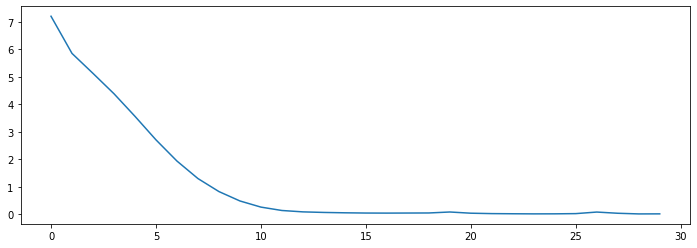

In [18]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1) 
ax.plot(np.arange(len(train_losses_epochs)), train_losses_epochs)

# 学習済み重みの読み込み + 予測

In [19]:
epoch = 30
model_path = os.path.join(model_weight_dir, f'ep_{epoch}.pth')
model_trained = torch.load(model_path)
model_trained

RNNModule(
  (embedding): Embedding(8910, 500)
  (lstm): LSTM(500, 1000, batch_first=True)
  (dense): Linear(in_features=1000, out_features=2000, bias=True)
  (final): Linear(in_features=2000, out_features=8910, bias=True)
)

In [21]:
for i in range(10):
    print('*'*20, 'generate_sentence: ', i, '*'*20,)
    generate_sentence = generate(model_trained, prime_str=['明日', 'の', '朝'], predict_len=100, temperature=0.8, device='cuda')
    pprint.pprint(' '.join(generate_sentence), width=70)

******************** generate_sentence:  0 ********************
('明日 の 朝 まで 心 に 見せ て 行っ た 燃える かも ね 花 の 中 また また 歩き 歩き たら 街 たら 街 は どこ '
 'か ？ Question 出 れる スペシャル temptation さよなら さよなら her take だけ ばかり で 今夜 '
 'たい Won れる can 僕ら の 電話 出 て みる た よ 戻っ な ん だ よ と 自由 じゃ た けど 期待 も 無駄 '
 'られ 「 あげる こりゃ の よう な もの が それ で それ で いい 人生 の 力 で 太陽 の ため いっそ れる 教え '
 'れる まま まかせ あっ た まま じゃっ All night まで も 感じ 感じ')
******************** generate_sentence:  1 ********************
('明日 の 朝 まで 飛ん に 朝日 は つい て いっ た 言葉 感じ て くる ブルー ブルー 前 に 電話 に My Love '
 'でき ない けど ？ な そんな 海 にゃ て 行く たく よ 帰り いる よ 自分 の 全部 ら いい よ 逃げ 毎日 て 一 ば '
 'いい よそ が 見える ああ 涙 の か 自分 を 変え てる よ 自分 を 解く て い た 言葉 も これ じゃ ず でも い '
 'て い た よ 自分 を 捨て て 歩い て 歩い て き た ん だ よ ひとつ の 中 の 言葉 も いら ない いっ は')
******************** generate_sentence:  2 ********************
('明日 の 朝 でも かまわ ない あなた が 体 なら 少々 抱きしめ する め こと こっち 時 の スピード が そば に 死ん '
 '( 気づい てる You の 教え & newsTV 海 を 守っ ない で ( It ) だ と 目 を 開け たら とたん て '
 'ゆく よ ( 追いかけ の 後ろ を 飛ん で これから ゆこ う 別々 ! Your say yeah way つぶれる

In [22]:
for i in range(10):
    print('*'*20, 'generate_sentence: ', i, '*'*20,)
    generate_sentence = generate(model_trained, prime_str=['波'], predict_len=100, temperature=0.8, device='cuda')
    pprint.pprint(' '.join(generate_sentence), width=70)

******************** generate_sentence:  0 ********************
('波 は Cryin is the ? of the end of the sky ve got ve got to the '
 'everywhereFor … 君 を 探し て 旅 すりゃ ゆっくり た まま of 誰 も 手 を のばし た わけ じゃ ない '
 'よ ちっぽけ 悲しい ve よ 逃げ だけ I can hear に つい て しまう & can ラスト GO hear つい '
 'ない BABY Love … もう 越せ ない 誰 に 笑顔 に 痛み は 汗 ます 度 が 好き よ 好き な ん なら Hi '
 '笑っ て くくれ 者 夏 の 前 に なり 歩い 道 流れる 綺麗 を さよなら つづける ( My')
******************** generate_sentence:  1 ********************
("波 ああ 素振り ' s crying crying enough ' s so lateI never lateI never … "
 'もう いい All Night 誰 に 続く れる が 楽 なる だろ う そんな 自分 の 自分 を タナ どんなに 新しい '
 'でしょ の でしょ う 自分 も どんなに 力 力 二 人 とか は でき ない 今 を 見つめ たい と 笑っ て 思う よう に '
 'ただ 思い出す に ゆく と 君 の よう に ゆく すべて は 本当に て ゆく の は 涙 の 色 を 色 よう に 互い '
 "ほんの 我がまま 涙 の 色 を 色 かけぬけ ' s gonna with your Devil")
******************** generate_sentence:  2 ********************
('波 は 踊っ いつ でも 君 の すべて が ひとり 声 想い 旅 に 入れ ない よう な 毎日 ない 嫉妬 を ひとり 列車 に '
 '汗 させ で turn そして 気 を 気がつけ た かい ラララ どこ に い する する する する つもり 夢 を 追いかけ '
 'た 君